In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

**Monthly dataset**

In [2]:
monthly_data = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None)
monthly_data.columns = ['Year', 'Month', 'Fractional Year', 'Sunspot Number', 'Std Dev', 'Observations', 'Indicator']
monthly_data_cleaned = monthly_data[monthly_data['Sunspot Number'] != -1]
monthly_data_cleaned['Date'] = pd.to_datetime(monthly_data_cleaned[['Year', 'Month']].assign(Day=1))
monthly_data_prepped = monthly_data_cleaned[['Date', 'Sunspot Number']].rename(columns={'Date': 'ds', 'Sunspot Number': 'y'})

**Defining and tune the Prophet model**

In [3]:
model = Prophet(growth='logistic', n_changepoints=20, changepoint_prior_scale=0.1)
model.add_seasonality(name='yearly', period=12, fourier_order=6)
monthly_data_prepped['cap'] = monthly_data_prepped['y'].max() + 50  # Adding logistic growth cap
model.fit(monthly_data_prepped)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7fovgs7e/c666a0me.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7fovgs7e/c8iff_f9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79734', 'data', 'file=/tmp/tmp7fovgs7e/c666a0me.json', 'init=/tmp/tmp7fovgs7e/c8iff_f9.json', 'output', 'file=/tmp/tmp7fovgs7e/prophet_modelsdkrl89p/prophet_model-20241128184643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] do

**Making predictions for 1, 6, and 9 months into the future**

In [4]:
future = model.make_future_dataframe(periods=9, freq='M')
future['cap'] = monthly_data_prepped['cap'].iloc[0]
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


**Plot the forecast**

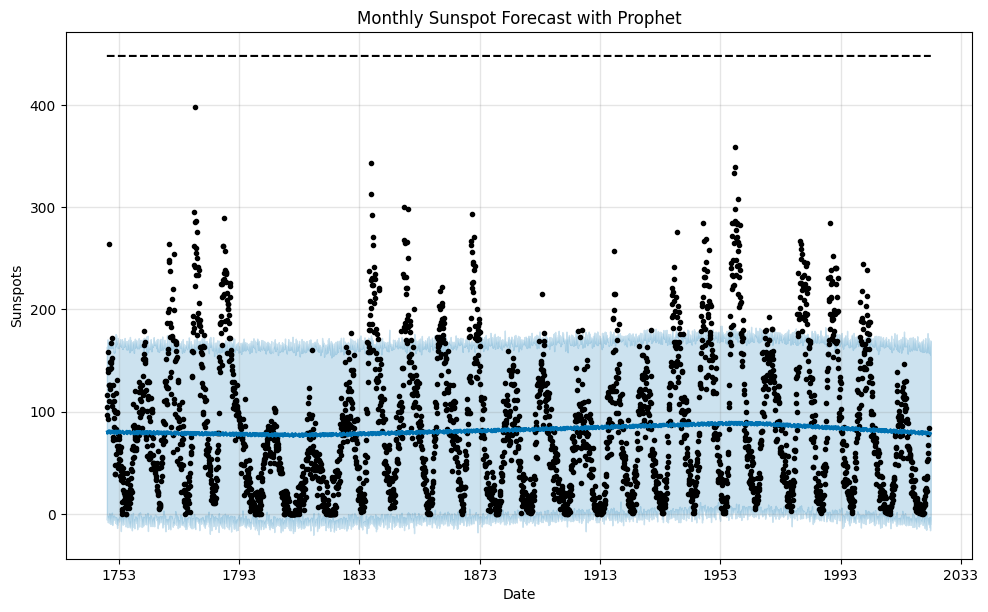

In [5]:
model.plot(forecast)
plt.title("Monthly Sunspot Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.savefig("monthly_forecast_plot.png")
plt.show()

**Filter predictions for specified intervals**

In [6]:
predicted_intervals = forecast.loc[forecast['ds'].isin(
    [future['ds'].iloc[-1], future['ds'].iloc[-6], future['ds'].iloc[-9]])]

**Evaluate the model**

In [7]:
history = forecast[forecast['ds'] <= monthly_data_prepped['ds'].max()]
mae = mean_absolute_error(monthly_data_prepped['y'], history['yhat'])
mape = np.mean(np.abs((monthly_data_prepped['y'] - history['yhat']) / monthly_data_prepped['y'])) * 100
r2 = r2_score(monthly_data_prepped['y'], history['yhat'])

**Saving the forecast**

In [8]:
forecast.to_csv('monthly_forecast.csv', index=False)

**Printing metrics and predictions**

In [9]:
print("Monthly Forecast Metrics:")
print(f"MAE: {mae}, MAPE: {mape}, R2: {r2}")
print("\nPredicted Sunspots for specified intervals:")
print(predicted_intervals[['ds', 'yhat']])

Monthly Forecast Metrics:
MAE: 54.69356991141634, MAPE: inf, R2: 0.012421608882157043

Predicted Sunspots for specified intervals:
             ds       yhat
3280 2022-04-30  78.071508
3283 2022-07-31  78.518850
3288 2022-12-31  78.762585
